In [1]:
import tensorflow as tf
import multiprocessing

# Définir explicitement l'utilisation de tous les cœurs disponibles
n_threads = multiprocessing.cpu_count()
tf.config.threading.set_intra_op_parallelism_threads(n_threads)
tf.config.threading.set_inter_op_parallelism_threads(n_threads)

In [2]:
from tensorflow.keras.datasets import boston_housing

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()

print("train")
print("x", x_train.shape)
print("y", y_train.shape)

print("test")
print("x", x_test.shape)
print("y", y_test.shape)

train
x (404, 13)
y (404,)
test
x (102, 13)
y (102,)


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

print(x_train_scaled.shape)
print(x_test_scaled.shape)

(404, 13)
(102, 13)


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import backend as K
from tensorflow.keras.saving import register_keras_serializable
import matplotlib.pyplot as plt

# Fonction pour calculer le R² qui n'est pas dispo dans Tensorflow:
@register_keras_serializable(package="Custom", name="r2_metric")
def r2_metric(y_true, y_pred):
    """
    Pour que TensorFlow puisse sauvegarder et recharger correctement le modèle,
    la fonction personnalisée doit être enregistrée à l'aide du décorateur @register...
    
    ss_res = sum of squares of residuals = somme des carrés des résidus (ou erreurs).
    ss_tot = sum of squares total = somme totale des carrés.
    K = module de backend de Tensorflow pour manipuler des tenseurs (objets mathématiques utilisés dans l'entraînement des modèles).
    """
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

class MonModelRegression:
    def __init__(self, input_dim, nb_units, activation):
        """ initialise l'instance de la classe:
            1 - les attributs
            2 - Création du réseau de neurones
            3 - Compilation du réseau """
        # attributs de ma classe
        self.input_dim = input_dim
        self.nb_units = nb_units
        self.activation = activation
        # Création du réseau de neurones
        self.MonReseau_creation()
        # Compilation du réseau
        self.MonReseau_compile()

    def MonReseau_creation(self):
        model = Sequential()
        # INPUT LAYER
        model.add(Input(shape=(self.input_dim,)))
        # HIDDEN LAYERS
        model.add(Dense(units=self.nb_units,
                        activation=self.activation))
        # OUTPUT LAYER
        model.add(Dense(units=1))
        self.model = model

    def MonReseau_compile(self):
        self.model.compile(optimizer="adam", 
              loss="mse",
              metrics=["mae", r2_metric])

    def train_model(self, x_train, y_train, x_test, y_test, batch_size=128, epochs=1000, verbose=True):
        self.history = self.model.fit(
            x_train, y_train,
            validation_data=(x_test, y_test),
            batch_size=batch_size,
            epochs=epochs,
            verbose=verbose
        )
           
    def predire(self, data):
        return self.model.predict(data)
    
    def plot_loss_mse(self):
        plt.figure()
        plt.plot(self.history.history["loss"], label="Training Loss (MSE)")
        plt.plot(self.history.history["val_loss"], label="Validation Loss (MSE)")
        plt.grid()
        plt.legend()
        plt.title("Mean Squared Error (MSE)")

    def plot_metric_mae(self):
        plt.figure()
        plt.plot(self.history.history["mae"], label="Training MAE")
        plt.plot(self.history.history["val_mae"], label="Validation MAE")
        plt.grid()
        plt.legend()
        plt.title("Mean Absolute Error (MAE)")

    def plot_metric_r2(self):
        # Vérifie si R² a été enregistré :
        if "r2_metric" in self.history.history:
            plt.figure()
            plt.plot(self.history.history["r2_metric"], label="Training R²")
            plt.plot(self.history.history["val_r2_metric"], label="Validation R²")
            plt.grid()
            plt.legend()
            plt.title("Coefficient de détermination (R²)")
    
    def save_model(self, chemin_fichier):
        """
        Sauvegarde le modèle complet au chemin spécifié.
        paramètre "chemin_fichier": chemin du fichier où sauvegarder le modèle
        (doit se terminer par .keras).
        """
        self.model.save(chemin_fichier)
        print(f"Modèle sauvegardé à l'emplacement : {chemin_fichier}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
=== Modèle de Régression Linéaire ===
Mean Squared Error (MSE): 23.1956
Mean Absolute Error (MAE): 3.4642
Coefficient de Détermination (R²): 0.7214
Temps d'entraînement: 0.0000 secondes
Temps de prédiction: 0.0000 secondes

=== Réseau de Neurones ===
Mean Squared Error (MSE): 17.1014
Mean Absolute Error (MAE): 2.5894
Coefficient de Détermination (R²): 0.7946
Temps d'entraînement: 84.5704 secondes
Temps de prédiction: 0.1170 secondes


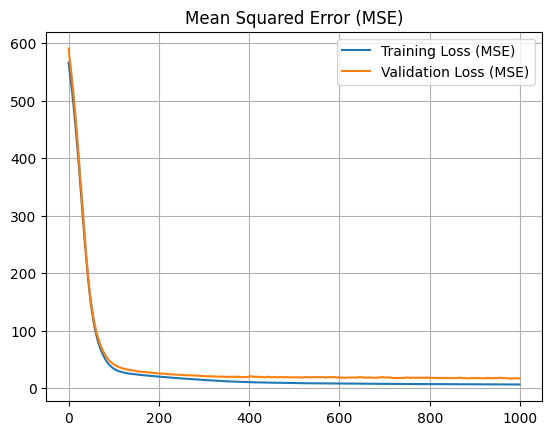

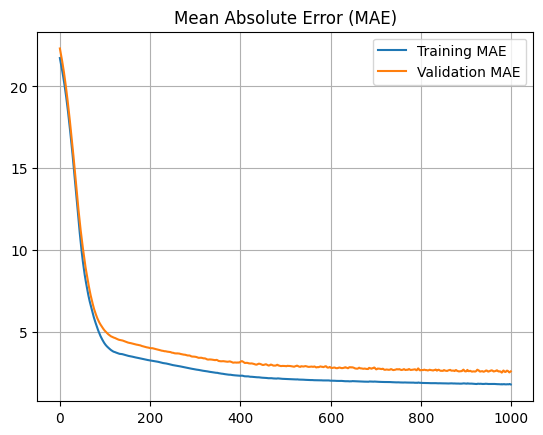

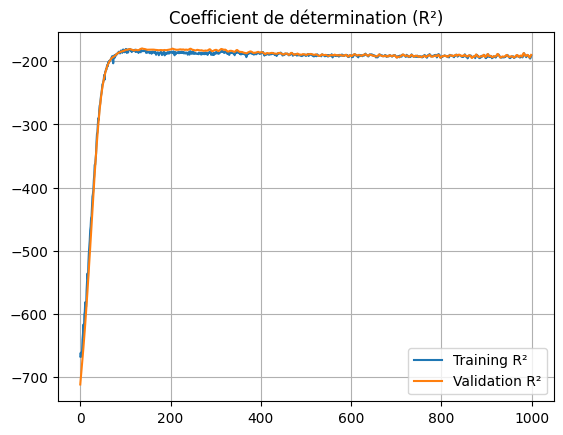

Modèle sauvegardé à l'emplacement : c:/Users/aboys/Documents/Simplon/Cours_Exos/Deep_Learning/Cours/mon_modele_regression.keras


In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time

# Régression Linéaire classique
start_time = time.time()
linear_model = LinearRegression()
linear_model.fit(x_train_scaled, y_train)
training_time_linear = time.time() - start_time

start_time = time.time()
y_pred_linear = linear_model.predict(x_test_scaled)
mse_linear = mean_squared_error(y_test, y_pred_linear)
mae_linear = mean_absolute_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)
predict_time_linear = time.time() - start_time

# Régression Linéaire par réseau de neurones
start_time = time.time()
model_regression = MonModelRegression(input_dim=x_train_scaled.shape[1], nb_units=64, activation="relu")
model_regression.train_model(x_train_scaled, y_train, x_test_scaled, y_test, verbose=False)
training_time_nn = time.time() - start_time

start_time = time.time()
y_pred_nn = model_regression.predire(x_test_scaled)
mse_nn = mean_squared_error(y_test, y_pred_nn)
mae_nn = mean_absolute_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
predict_time_nn = time.time() - start_time

# Résultats
print("=== Modèle de Régression Linéaire ===")
print(f"Mean Squared Error (MSE): {mse_linear:.4f}")
print(f"Mean Absolute Error (MAE): {mae_linear:.4f}")
print(f"Coefficient de Détermination (R²): {r2_linear:.4f}")
print(f"Temps d'entraînement: {training_time_linear:.4f} secondes")
print(f"Temps de prédiction: {predict_time_linear:.4f} secondes")

print("\n=== Réseau de Neurones ===")
print(f"Mean Squared Error (MSE): {mse_nn:.4f}")
print(f"Mean Absolute Error (MAE): {mae_nn:.4f}")
print(f"Coefficient de Détermination (R²): {r2_nn:.4f}")
print(f"Temps d'entraînement: {training_time_nn:.4f} secondes")
print(f"Temps de prédiction: {predict_time_nn:.4f} secondes")

model_regression.plot_loss_mse()
model_regression.plot_metric_mae()
model_regression.plot_metric_r2()
plt.show()

# Sauvegarde du modèle
model_regression.save_model("c:/Users/aboys/Documents/Simplon/Cours_Exos/Deep_Learning/Cours/mon_modele_regression.keras")

In [6]:
from tensorflow.keras.models import load_model

# Charger le modèle avec les objets personnalisés
custom_objects = {"r2_metric": r2_metric}
model_reg_charge = load_model(
    "c:/Users/aboys/Documents/Simplon/Cours_Exos/Deep_Learning/Cours/mon_modele_regression.keras",
    custom_objects=custom_objects
)

model_reg_charge.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,885 (11.27 KB)

 Trainable params: 961 (3.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,924 (7.52 KB)